<a href="https://colab.research.google.com/github/OctavioGuaschi/IA901-2023S1/blob/main/projetos/Human_physical_position_detection/notebooks/Detec%C3%A7%C3%A3o_de_posi%C3%A7%C3%A3o_f%C3%ADsica_humana_Efficientnet_B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Octavio S Guaschi, 218390

---


Breno Portela, 253502

---


Cesar Bastos, 264521

---



Notebook de implementação de detecção de posição física humana

# Imports

In [ ]:
#@title Drive Mount
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = "gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_no_bending_dataset"

Mounted at /content/gdrive


In [ ]:
#@title Python Imports
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Neptune Config

In [ ]:
! pip install neptune-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.4/450.4 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.8 MB/s eta 0:00:00


A partir da função a seguir, foi possível registrar os modelos de rede de melhor performance.

In [ ]:
#@title Neptune Function for Pickle
import neptune.new as neptune
from neptune.types import File


def neptune_start(name='Default'):
    run = neptune.init_run (project= 'octavioguaschi/IA901-218390',
                       name=name,
                       api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTM4ZmY5My1iMzE5LTQ0MzQtOTA5MS02MzUzZTkxYTI0OGIifQ==")
    return run



/usr/local/lib/python3.10/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-4-df3ed7d629c0>:2: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


# Dataset Loader


In [ ]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

Foi necessário um resize para a resolução de 170x170 devido a limitação de memória na GPU

In [ ]:
#@title Transforms and Dataloaders
# Data transforms for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor()
    ])
}

# Dataset for training
image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Dataloader for training
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=True, num_workers=2) for x in ['train', 'val']}

# Train 2169 (60%), Val 724 (20%), Test 723 (20%)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Seed lock for reprodutibility
seed = 2809

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
print(dataset_sizes)
print(class_names)

{'train': 2169, 'val': 724}
['lying', 'sitting', 'standing']


Batch of training data


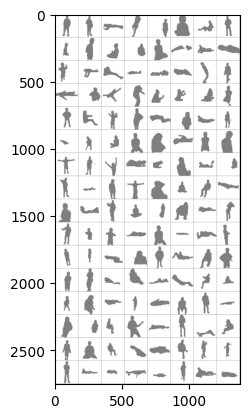

Batch of validation data


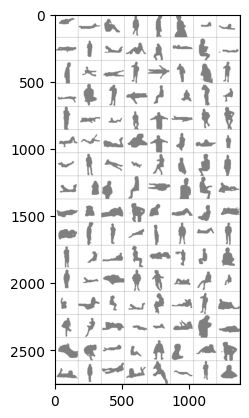

In [ ]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes, _ = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)


print('Batch of validation data')
inputs, classes, _ = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

# Função do treinamento com Neptune

Com o uso do neptune, foram registrados os modelos treinados, sendo possível rastrear seu comportamento e selecionar o de melhor desempenho

In [ ]:
#@title Train Function
def train_model_Neptune(model, criterion, optimizer, scheduler,neptune, num_epochs):
    since = time.time()
    run = neptune
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    PARAMS = {'model': model,
              'nb_epoch': num_epochs,
              'criterion': 'Cross',
              'optimizer': optimizer.defaults,
        }
    run['PARAMS'] = PARAMS


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                run['train/epoch_loss'].append(epoch_loss)
                run['train/epoch_acc'].append(epoch_acc)
            if phase == 'val':
                run['val/epoch_loss'].append(epoch_loss)
                run['val/epoch_acc'].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    run["acc"] = best_acc
    run["time_elapsed"] = time_elapsed
    # load best model weights
    model.load_state_dict(best_model_wts)
    run["model/pickled_model"].upload(File.as_pickle(model))
    return model


# Modelo

O modelo selecionado foi o modelo pré-treinado EfficientNet-B2, devido a seu bom resultado em accuracy e sua baixa quantidade de parametros, sendo possível um bom resultado utilizando uma baixa quantidade de memória.

In [ ]:
#@title Efficientnet-B2

model_efficientnet_b2 = models.efficientnet_b2(pretrained = True)
num_ftrs_efficientnet_b2 = model_efficientnet_b2.classifier[1].in_features
model_efficientnet_b2.classifier[1] = nn.Linear(num_ftrs_efficientnet_b2, len(class_names))
model_efficientnet_b2 = model_efficientnet_b2.to(device)
optimizer_efficientnet_b2 = optim.SGD(model_efficientnet_b2.parameters(), lr=0.0007, momentum=0.9)
exp_lr_scheduler_efficientnet_b2 = lr_scheduler.StepLR(optimizer_efficientnet_b2, step_size=200, gamma=0.5)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 145MB/s]


# Treinamento e Teste da Rede

A seguir o treinamento é realizado

## Efficientnet-B2

In [ ]:
#@title Treinamento

run = neptune_start('model_efficientnet_b2')
model_efficientnet_b2 = train_model_Neptune(model_efficientnet_b2, criterion, optimizer_efficientnet_b2,
                                           exp_lr_scheduler_efficientnet_b2, run, 30)
run.stop()

https://app.neptune.ai/octavioguaschi/IA901-218390/e/IA90-191
Epoch 0/29
----------
train Loss: 0.8801 Acc: 0.6851
val Loss: 0.9947 Acc: 0.5152

Epoch 1/29
----------
train Loss: 0.7192 Acc: 0.7856
val Loss: 0.7947 Acc: 0.7362

Epoch 2/29
----------
train Loss: 0.5996 Acc: 0.8197
val Loss: 0.6598 Acc: 0.8191

Epoch 3/29
----------
train Loss: 0.5248 Acc: 0.8271
val Loss: 0.5703 Acc: 0.8287

Epoch 4/29
----------
train Loss: 0.4616 Acc: 0.8520
val Loss: 0.5588 Acc: 0.8343

Epoch 5/29
----------
train Loss: 0.4176 Acc: 0.8608
val Loss: 0.4504 Acc: 0.8591

Epoch 6/29
----------
train Loss: 0.3839 Acc: 0.8691
val Loss: 0.4351 Acc: 0.8467

Epoch 7/29
----------
train Loss: 0.3487 Acc: 0.8884
val Loss: 0.3831 Acc: 0.8757

Epoch 8/29
----------
train Loss: 0.3277 Acc: 0.8875
val Loss: 0.3728 Acc: 0.8757

Epoch 9/29
----------
train Loss: 0.3054 Acc: 0.9018
val Loss: 0.3293 Acc: 0.8909

Epoch 10/29
----------
train Loss: 0.2888 Acc: 0.9050
val Loss: 0.3707 Acc: 0.9047

Epoch 11/29
----------
t